# Basic usage

In this tutorial, we illustrate the basic usage of the toolbox to simulate MEG/EEG. We show how to simulate data with "ground truth" effects and, then test whether a decoding analysis can successfully detect those effects. This guides new users through the typical workflow: defining an experimental design, specifying when each effect should be present in time, generating data, and finally verifying that a chosen analysis pipeline can uncover the artificially injected effects.

Below, we walk through a minimal but representative example of a 2x2 experimental design

## 1. Defining an Experimental Design

Imagine we have a simple 2x2 experimental design, in which we present trials of 2 different categories (say faces and objects) displayed in two different attention condition (attended vs. unattended condition). In each attention condition, we present 40 faces and 40 objects, resulting in a total of 160 trials. Our design matrix has 160 rows (1 per trial) and 2 columns: 

| Category    | Attention |
| -------- | ------- |
| face | attended    |
| face | unattended     |
| object| attended    |
| object| unattended    |
| ...| ...    |

In this design matrix, we encode each condition as 1 and -1 (face: 1, object: -1, attended: 1, unattended: -1). The toolbox requires the design matrix to be a pandas data frame

In [1]:
import numpy as np
import pandas as pd

# Creating the design matrix of our 2 by two balanced design:
X = np.array([[1, 1, -1, -1] * 40, [1, -1] * 80]).T

# Add descriptors:
cond_names = ["category", "attention"]
X = pd.DataFrame(X, columns=cond_names)  # Add a column for the interaction between category and attention
mapping = {
    "category": {1: "face", -1: "object"},
    "attention": {1: "attended", -1: "unattended"},
}

## 2. Specifying multivariate effects in the data

To specify an effect, we need to create a dictionary that specifies:

- condition: the name of the experimental condition it corresponds to (matching the column name of your design matrix)
- The time window at which it is present
- The size of the effect

Below, we specify a multivariate effect of category from 0.1 to 0.2s and an effect of attention from 0.3 to 0.5s, each with an effect size of 0.5

In [2]:
category_effect = {
    "condition": 'category',
    "windows": [0.1, 0.2],
    "effect_size": 0.5
}

attention_effect = {
    "condition": 'attention',
    "windows": [0.3, 0.4],
    "effect_size": 0.5
}

effects = [category_effect, attention_effect]  # Packaging them in a list to pass to the simulator class

## 3. Specifying the characteristics of the data

Next, we need to specify the characteristics of the data:

- n_channels: the number of channels of the MEG/EEG recordings we plan to analyze
- sfreq: the sampling frequency of our signal
- n_subjects: the number of subjects for our virtual data set
- s: observation noise
- ch_cov: the spatial covariance of the data we want to simulate

The aim of this toolbox is to simulate data with known ground truth effect to validate your analysis pipelines capacity to detect effects in your real data. It is important to specify parameters that match your actual data to make sure that the results you obtain on simulated data will generalize to your real data: same number of channels, same number of subjects. We also strongly recommend that the observation noise and spatial covariance matches your actual data.

For illustrations' sake, let's say we are working with an EEG system recording **32 channels** and that we collected **20 participants**. We specify an identity covariance matrix and set the observation noise to 0.5.

In [3]:
n_channels = 32  # EEG system with 32 electrodes
n_subjects = 20  # Recording from 20 subjects
noise_std = 1 / 2  # Variance of the data
ch_cov = None  # Assuming that the data of each sensor are independent
sfreq = 50  # Simulating data at 50Hz

## 4. Simulating the data

We can simulate the data by passing all the parameters we have specified to teh simulator function. We also show how to convert the data to MNE format to make use of their decoding pipelines. We also show how to export to EEG lab is this is your preferred toolbox.

In [ ]:
from multisim import Simulator

sims = Simulator(
    X,  # Design matrix
    effects,    # effects to simulate
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    n_subjects,  # Number of subjects
    -0.25,
    1.0,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    ch_cov=ch_cov,  # Spatial covariance of the data
)
print(sims)

# Convert to MNE epochs:
epochs = sims.export_to_mne(X=X.copy(), mapping=mapping)

# Alternatively, save to eeglab format
sims.export_to_eeglab(
    X=X.copy(),
    mapping=mapping,
    root="./data",
    fname_template="sub-{:02d}_task-sim-epo.set",
)

Subjects  : 20
Epochs    : 160
Samples   : 61
Channels  : 32
Conditions: 2 (category, attention)


## 5. Vizualizing the data:

We can have a quick look at our simulated data. It won't look like much, given that we have simulated multivariate effects without much else at all. It won't look like actual MEG/EEG data:

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated


C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_2964\482823938.py:1: RuntimeWarning: Only one channel in group "CH000"; cannot combine by method "mean".
  epochs[0].plot_image(picks=[0], combine="mean", scalings=dict(eeg=1))
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_2964\482823938.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  epochs[0].plot_image(picks=[0], combine="mean", scalings=dict(eeg=1))


combining channels using "mean"


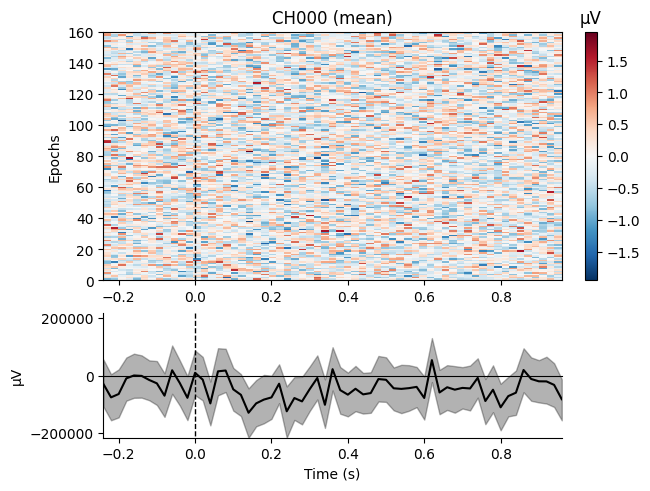

[<Figure size 640x480 with 3 Axes>]

In [ ]:
epochs[0].plot_image(picks=[0], scalings=dict(eeg=1));

## 6. Decoding analysis

Once you have simulated the data, you can validate your pipeline by running it on the simulated data to make sure that the effects you know to be present are detected. To illustrate it, we use the standard MNE decoding pipeline to decode the simulated effects in a time resolved fashion.

### 6.1. Within subject analysis:
We can try to decode each of the labels of interest (face vs. objects and attended vs. unattended) for a given subject and we will see that these effects are present at the expected time points:

Text(0.5, 1.0, 'Sensor space decoding')

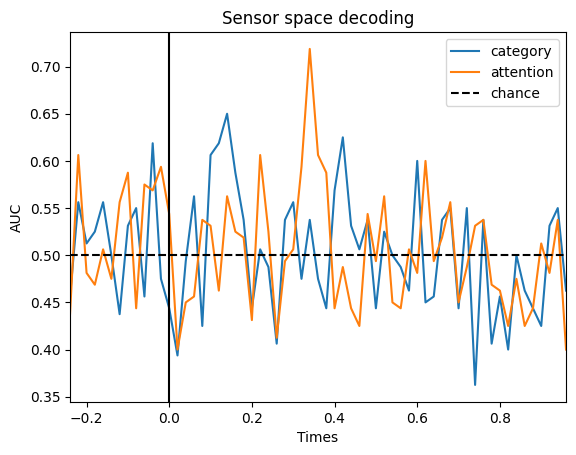

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator, cross_val_multiscore

# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="accuracy", verbose=True)

# Extract the data:
data = epochs[0].get_data()

# Decode faces vs. objects:
cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])
scores_category = np.mean(
    cross_val_multiscore(
        time_decod, data, cate_lbl, cv=5, n_jobs=-1, verbose="WARNING"
    ),
    axis=0,
)

# Decode attended vs. unattended:
att_lbl = np.array([mapping["attention"][val] for val in X.to_numpy()[:, 1]])
scores_attention = np.mean(
    cross_val_multiscore(
        time_decod, data, att_lbl, cv=5, n_jobs=-1, verbose="WARNING"
    ),
    axis=0,
)

# Plot
fig, ax = plt.subplots()
ax.plot(epochs[0].times, scores_category, label="category")
ax.plot(epochs[0].times, scores_attention, label="attention")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

### 6.2. Group level analysis
We simulated the data of 20 subjects, so we can investigate the evidence for decoding of the experimental manipulations at the group level. First, we need to perform the decoding on every single subject:

In [7]:
from mne.stats import permutation_cluster_1samp_test, bootstrap_confidence_interval

scores_category = []
scores_attention = []

# Loop through each subject:
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )
    # Classification of attention:
    scores_attention.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, att_lbl, cv=5, n_jobs=-1, verbose="WARNING"
            ),
            axis=0,
        )
    )

scores_category = np.array(scores_category)
scores_attention = np.array(scores_attention)

We can then apply a cluster based permutation test across subjects to find out when we have an effect:

In [8]:
# Cluster based permutation test for the category:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    scores_category - 0.5,
    n_permutations=1024,
    tail=1,
    out_type="mask",
    verbose=True,
)
sig_mask_cate = np.zeros(len(epochs[0].times), dtype=bool)
for c, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        sig_mask_cate[clusters[c]] = True

# Cluster based permutation test for the attention:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    scores_attention - 0.5,
    n_permutations=1024,
    tail=1,
    out_type="mask",
    verbose=True,
)
sig_mask_att = np.zeros(len(epochs[0].times), dtype=bool)
for c, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        sig_mask_att[clusters[c]] = True

Using a threshold of 1.729133
stat_fun(H1): min=-2.063440557640801 max=13.915856477893735
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Using a threshold of 1.729133
stat_fun(H1): min=-3.190603052904803 max=11.712562295393171
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

Based on the input to the simulation, we would expect to see a significantly above chance decoding of face vs. object from 0.1 to 0.2 s, and then of attention from 0.3 to 0.4s. Let's check whether that is the case:

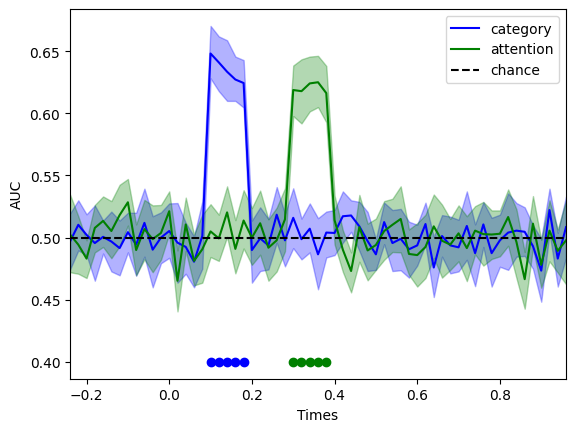

In [9]:
# Compute the confidence intervals:
ci_low_cate, ci_up_cate = bootstrap_confidence_interval(scores_category)
ci_low_att, ci_up_att = bootstrap_confidence_interval(scores_attention)

fig, ax = plt.subplots()
ax.plot(epochs[0].times, np.mean(scores_category, axis=0), label="category", color="b")
ax.fill_between(epochs[0].times, ci_low_cate, ci_up_cate, alpha=0.3, color="b")
ax.plot(
    epochs[0].times[sig_mask_cate],
    np.ones(np.sum(sig_mask_cate)) * 0.4,
    marker="o",
    linestyle="None",
    color="b",
)

ax.plot(
    epochs[0].times, np.mean(scores_attention, axis=0), label="attention", color="g"
)
ax.fill_between(epochs[0].times, ci_low_att, ci_up_att, alpha=0.3, color="g")
ax.plot(
    epochs[0].times[sig_mask_att],
    np.ones(np.sum(sig_mask_att)) * 0.4,
    marker="o",
    linestyle="None",
    color="g",
)
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.set_ylabel("AUC")
ax.legend()
plt.show()

Just as one would expect, we find significant decoding in the expected time windows. This makes designing decoding analysis (or any multivariate techniques such as RSA) very easy, as one can be sure that mistakes crept in, and that the pipeline is sensitive and specific enough

In the next tutorial, we will explore how to make the temporal dynamics of the multivariate signal more realistic, by adding a temporal kernel to our effect